## Problem Stement : Incorporate user's feedback into a DeepNet ML model

Any ML system is bound to make mistakes in prediction. The idea is to further, train the system to prevent it from making these mistakes again.

In many MLK systems the output of the ML system is directly presented to end user. The end user has choice of letting the sytem know 
    1) if the prediction(s) of the system were correct or not
    2) If a specific prediction was incorrect, what is the correct answer to it. 
    
We will like to teach the system from this user feedback.


The idea here is to see if we choose different learning rates for different datapoints

______________________________________________________________

To concetise the experiment:

    1. We train a simple DeepNet on MNIST data - images of handwritten digits. Task is to identify the digit (0-9) 
    2. Trained model is used make predictions on test Data
    3. Assume the actual image and predicted class are shown to a human user
    4. Human user can tell the system - if the prediction is wrong and what is the correct class for that image this (assume that the judgement of the user is supreme)
    
    5) Based on the feedback, Train the model to learn to predict correct class for this data point.
    
Here, user feedback is mimiced using actual label of the data point

--------------

### Section 1 - train the model in batch mode 

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (7,7) # Make the figures a bit bigger
from time import time


from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils

Using Theano backend.
/Users/admin/.virtualenvs/keras_0_3_2/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [3]:
nb_classes = 10

# get the data, shuffle it and split between tran and test sets
(X_train_org, y_train_org), (X_test_org, y_test_org) = mnist.load_data()
print("X_train original shape", X_train_org.shape)
print("y_train original shape", y_train_org.shape)
print("X_test original shape", X_test_org.shape)
print("y_test original shape", y_test_org.shape)

('X_train original shape', (60000, 28, 28))
('y_train original shape', (60000,))
('X_test original shape', (10000, 28, 28))
('y_test original shape', (10000,))


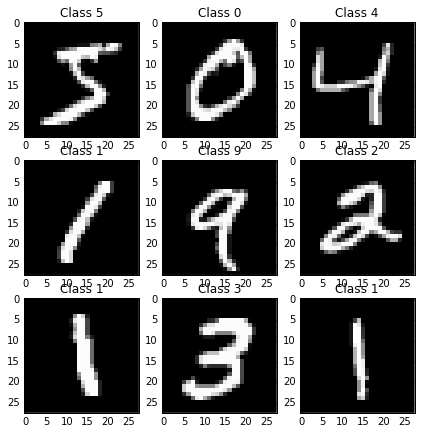

In [4]:
# lets see how the data looks like

for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_train_org[i], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train_org[i]))

In [5]:
# Copy the data to alter its formatting, maintain original data as it is

X_train = X_train_org
y_train = y_train_org
X_test = X_test_org
y_test = y_test_org

In [6]:
# process the data and make it ready for consumption

X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

('Training matrix shape', (60000, 784))
('Testing matrix shape', (10000, 784))


In [7]:
# process the labels - get 1-hot representation for the 10 classes

Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

In [8]:
# define the architecture of your DeepNet model

model = Sequential()
model.add(Dense(512, input_shape=(784,)))
model.add(Activation('relu')) # An "activation" is just a non-linear function applied to the output
                              # of the layer above. Here, with a "rectified linear unit",
                              # we clamp all values below 0 to 0.
                           
model.add(Dropout(0.4))   # Dropout helps protect the model from memorizing or "overfitting" the training data
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation('softmax'))

In [9]:
# get an optimizer

from keras.optimizers import SGD

sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd)

In [10]:
# print optimizer values

m = model.get_config()

m['optimizer']

{'decay': 9.999999974752427e-07,
 'lr': 0.10000000149011612,
 'momentum': 0.8999999761581421,
 'name': 'SGD',
 'nesterov': True}

In [11]:
# train the model in batch mode

offline_history = model.fit(X_train, Y_train,
          batch_size=128, nb_epoch=16,
          show_accuracy=True, verbose=1,
            validation_data=(X_test, Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/16
60000/60000 [==============================] - 5s - loss: 0.3302 - acc: 0.8974 - val_loss: 0.1297 - val_acc: 0.9579
Epoch 2/16
60000/60000 [==============================] - 5s - loss: 0.1790 - acc: 0.9466 - val_loss: 0.0984 - val_acc: 0.9682
Epoch 3/16
60000/60000 [==============================] - 6s - loss: 0.1429 - acc: 0.9577 - val_loss: 0.0924 - val_acc: 0.9713
Epoch 4/16
60000/60000 [==============================] - 6s - loss: 0.1270 - acc: 0.9615 - val_loss: 0.0838 - val_acc: 0.9743
Epoch 5/16
60000/60000 [==============================] - 6s - loss: 0.1130 - acc: 0.9659 - val_loss: 0.0835 - val_acc: 0.9750
Epoch 6/16
60000/60000 [==============================] - 6s - loss: 0.1006 - acc: 0.9695 - val_loss: 0.0710 - val_acc: 0.9787
Epoch 7/16
60000/60000 [==============================] - 7s - loss: 0.0980 - acc: 0.9700 - val_loss: 0.0713 - val_acc: 0.9780
Epoch 8/16
60000/60000 [==============================] - 7s 

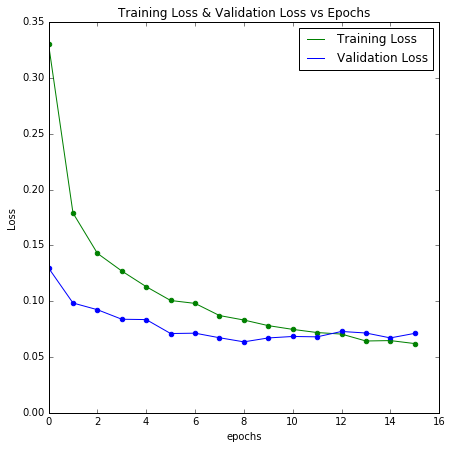

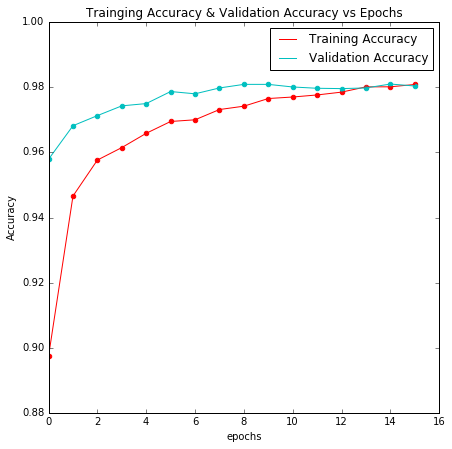

In [12]:
#summerise the training using graphs

hist = offline_history

plt.figure(1)

axes = plt.gca()
x_min = hist.epoch[0]
x_max = hist.epoch[-1]+1
axes.set_xlim([x_min,x_max])

plt.scatter(hist.epoch, hist.history['loss'], color='g')
plt.plot(hist.history['loss'], color='g', label='Training Loss')
plt.scatter(hist.epoch, hist.history['val_loss'], color='b')
plt.plot(hist.history['val_loss'], color='b', label='Validation Loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title('Training Loss & Validation Loss vs Epochs')
plt.legend()

plt.figure(2)

axes = plt.gca()
x_min = hist.epoch[0]
x_max = hist.epoch[-1]+1
axes.set_xlim([x_min,x_max])

plt.scatter(hist.epoch, hist.history['acc'], color='r')
plt.plot(hist.history['acc'], color='r', label='Training Accuracy')
plt.scatter(hist.epoch, hist.history['val_acc'], color='c')
plt.plot(hist.history['val_acc'], color='c', label='Validation Accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.title('Trainging Accuracy & Validation Accuracy vs Epochs')
plt.legend()

plt.show()

In [13]:
#evaluate the model on testing data

loss, acc = model.evaluate(X_test, Y_test,
                       show_accuracy=True, verbose=0)
print('Test score:', loss)
print('Test accuracy:', acc)

('Test score:', 0.071184771880682091)
('Test accuracy:', 0.98040000000000005)


In [14]:
def prediction_on_test_data():

    # The predict_classes function outputs the highest probability class according to the trained classifier for each input example.
    predicted_classes = model.predict_classes(X_test)

    # Check for which datapoints in test set we got right / wrong
    correct_indices = np.nonzero(predicted_classes == y_test)[0]
    incorrect_indices = np.nonzero(predicted_classes != y_test)[0]

    # print the number of right and wrongs we got on the test data
    print "# of correctly classified instances %d" %(len(correct_indices))
    print "# of wrongly classified instances %d" %(len(incorrect_indices))
    
    accuracy = (len(correct_indices) / (float(len(correct_indices) + len(incorrect_indices))))*100.0
    
    print "Accuracy = %.2f" %(accuracy)
    
    return (correct_indices,incorrect_indices)

In [15]:
(correct_indices,incorrect_indices) = prediction_on_test_data()

10000/10000 [==============================] - 0s     
# of correctly classified instances 9804
# of wrongly classified instances 196
Accuracy = 98.04


### Section 2 - identify mistakes

[ 65 115 149 247 321 340 432 445 447]
65


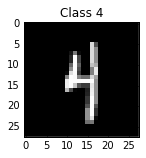

115


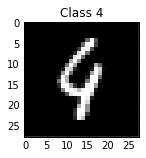

149


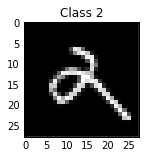

247


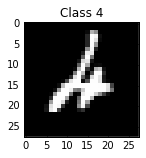

321


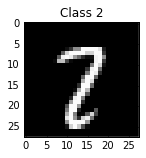

340


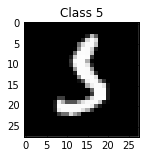

432


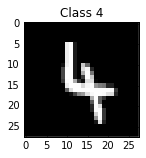

445


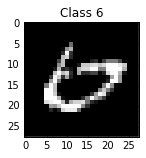

447


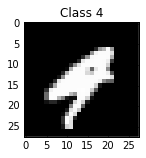

[448 449 495 582 619 646 684 691 707]
448


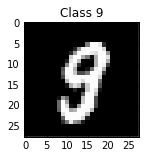

449


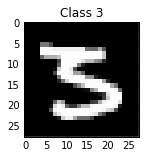

495


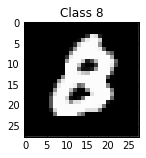

582


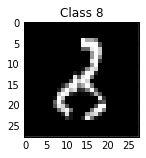

619


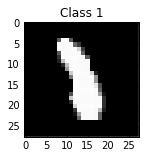

646


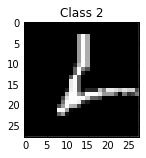

684


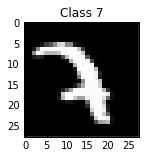

691


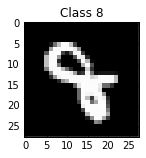

707


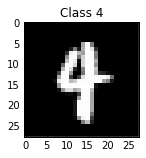

[ 720  740  839  900  947  956 1014 1039 1044]
720


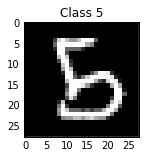

740


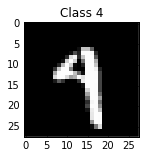

839


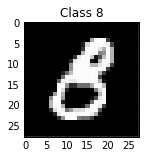

900


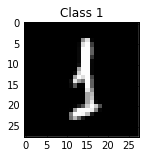

947


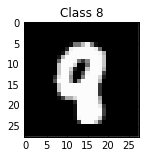

956


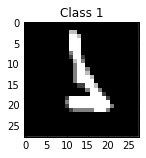

1014


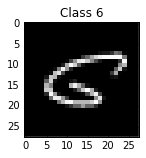

1039


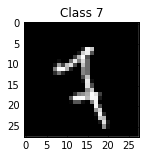

1044


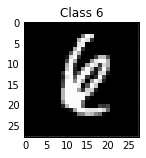

[1112 1156 1178 1181 1182 1226 1232 1242 1247]
1112


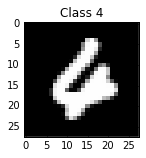

1156


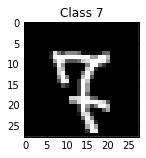

1178


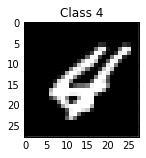

1181


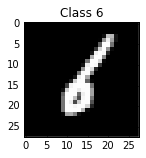

1182


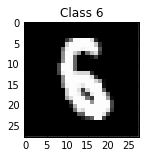

1226


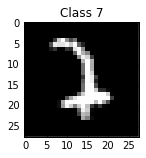

1232


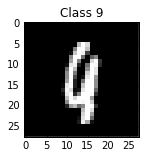

1242


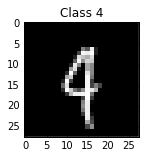

1247


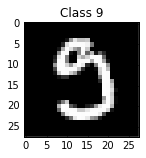

[1260 1319 1328 1494 1522 1530 1549 1553 1609]
1260


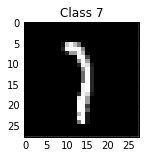

1319


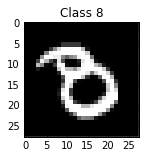

1328


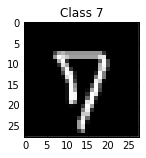

1494


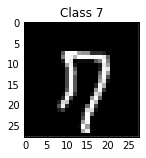

1522


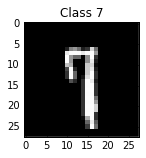

1530


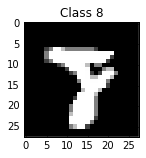

1549


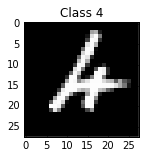

1553


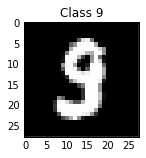

1609


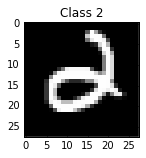

[1621 1681 1751 1754 1790 1901 1909 2035 2053]
1621


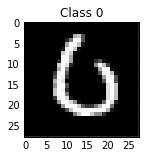

1681


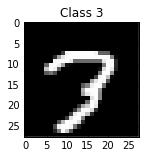

1751


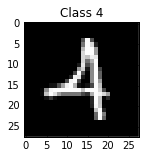

1754


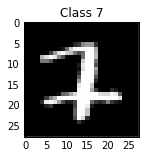

1790


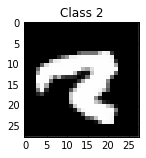

1901


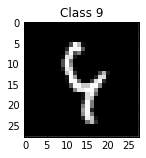

1909


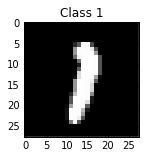

2035


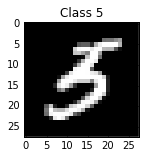

2053


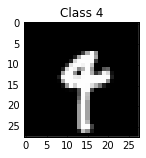

[2070 2109 2118 2129 2130 2135 2182 2185 2189]
2070


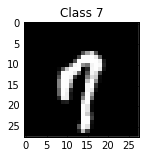

2109


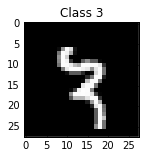

2118


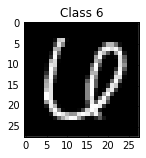

2129


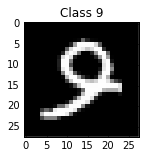

2130


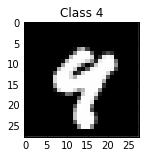

2135


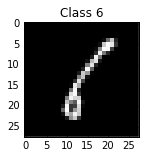

2182


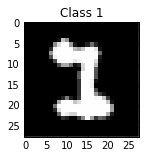

2185


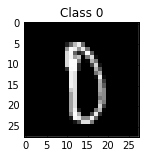

2189


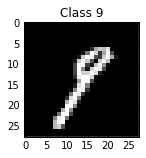

[2272 2293 2369 2387 2395 2406 2408 2422 2447]
2272


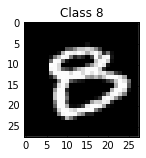

2293


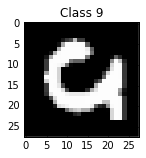

2369


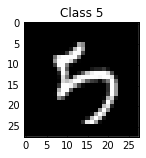

2387


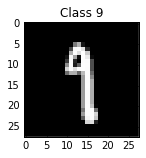

2395


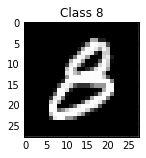

2406


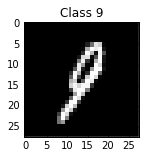

2408


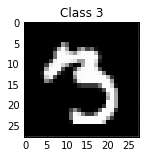

2422


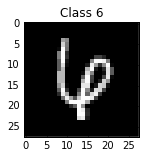

2447


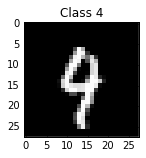

[2598 2648 2654 2770 2810 2877 2921 2927 2939]
2598


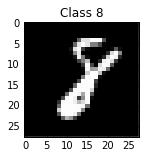

2648


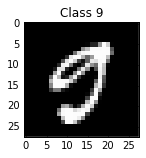

2654


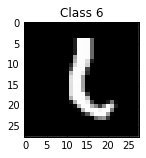

2770


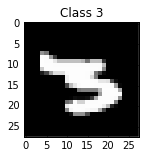

2810


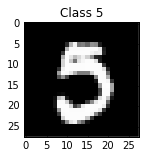

2877


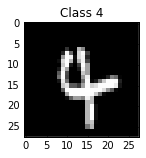

2921


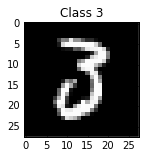

2927


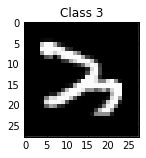

2939


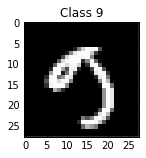

[2953 3073 3117 3206 3225 3388 3405 3422 3475]
2953


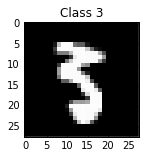

3073


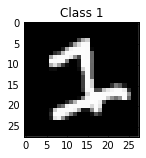

3117


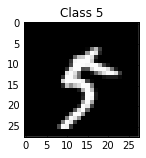

3206


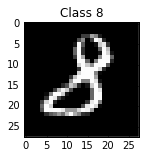

3225


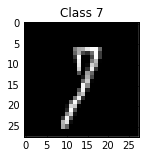

3388


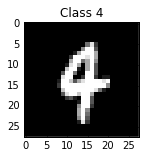

3405


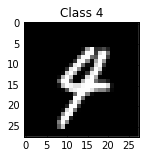

3422


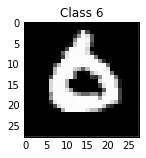

3475


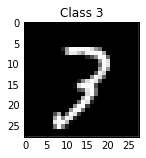

[3503 3520 3558 3597 3604 3629 3767 3776 3780]
3503


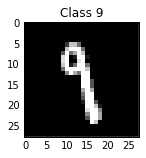

3520


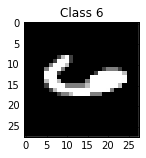

3558


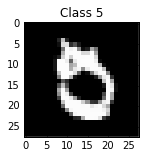

3597


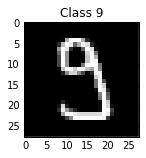

3604


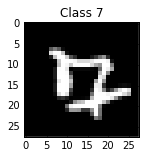

3629


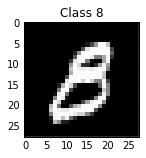

3767


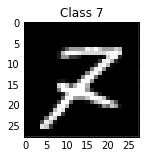

3776


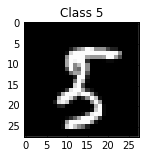

3780


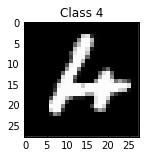

[3808 3853 3906 3941 3976 3985 4007 4027 4065]
3808


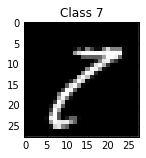

3853


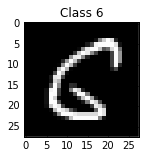

3906


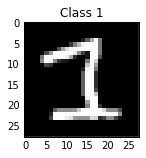

3941


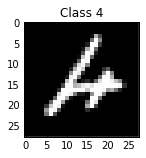

3976


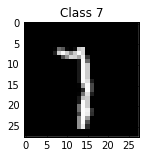

3985


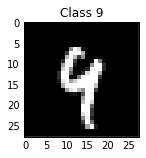

4007


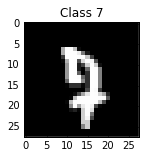

4027


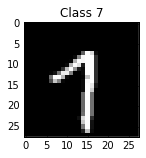

4065


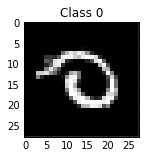

[4075 4163 4176 4201 4224 4248 4289 4317 4382]
4075


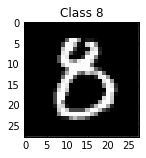

4163


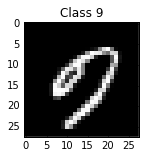

4176


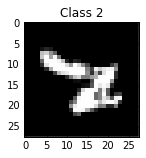

4201


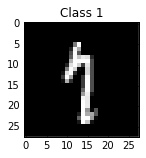

4224


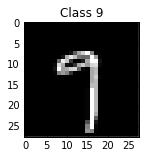

4248


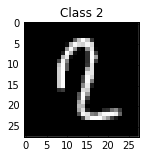

4289


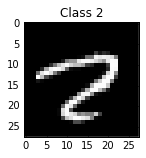

4317


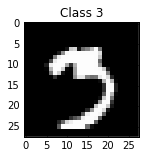

4382


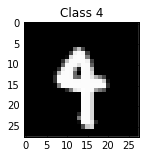

[4437 4477 4497 4536 4571 4601 4635 4639 4690]
4437


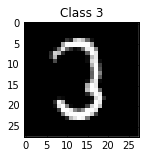

4477


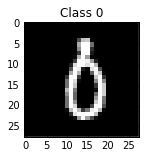

4497


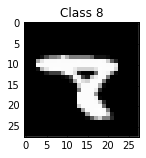

4536


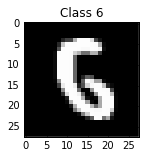

4571


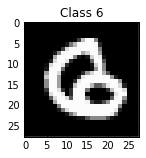

4601


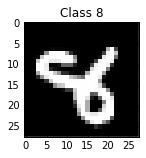

4635


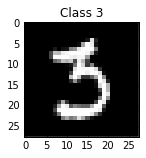

4639


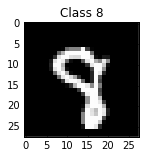

4690


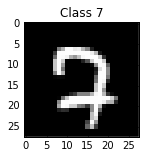

[4751 4807 4814 4823 4879 4880 4890 4956 4966]
4751


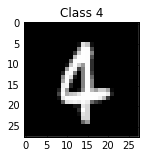

4807


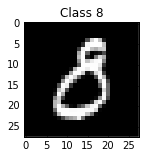

4814


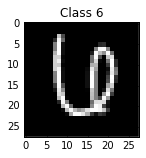

4823


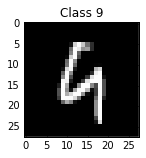

4879


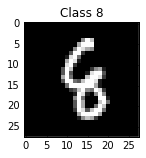

4880


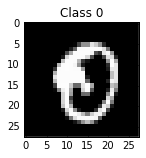

4890


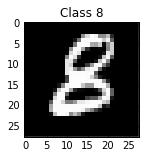

4956


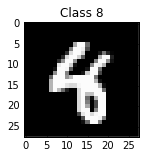

4966


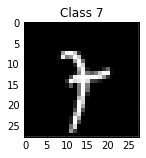

[4990 5331 5457 5600 5634 5642 5676 5734 5936]
4990


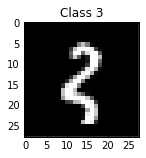

5331


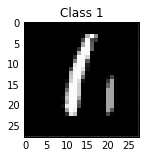

5457


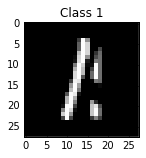

5600


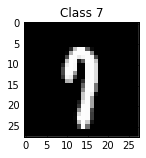

5634


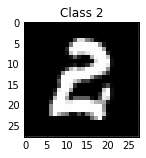

5642


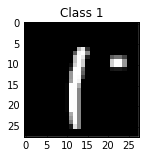

5676


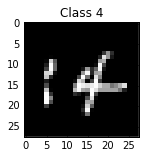

5734


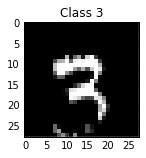

5936


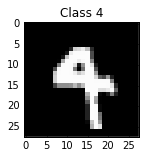

[5955 5973 6011 6023 6024 6059 6166 6173 6426]
5955


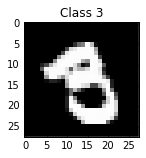

5973


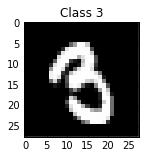

6011


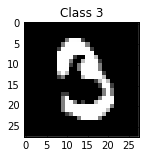

6023


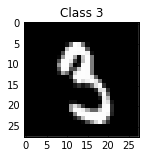

6024


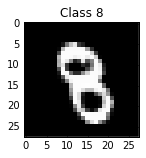

6059


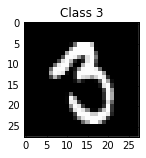

6166


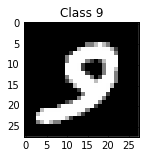

6173


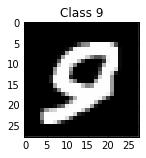

6426


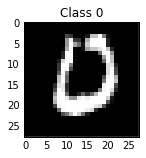

[6555 6560 6571 6572 6576 6597 6625 6632 6641]
6555


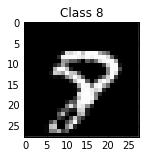

6560


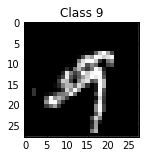

6571


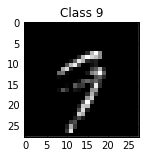

6572


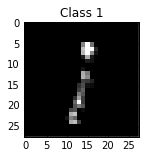

6576


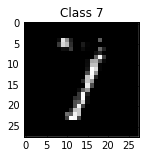

6597


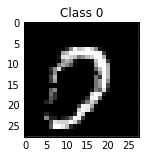

6625


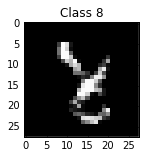

6632


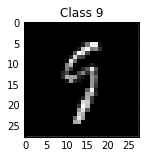

6641


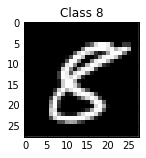

[6651 6740 6755 6759 6783 7233 7812 7856 7899]
6651


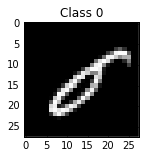

6740


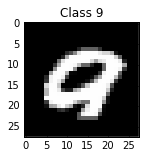

6755


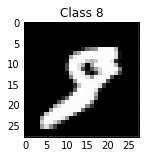

6759


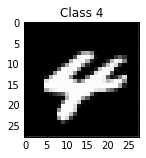

6783


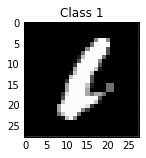

7233


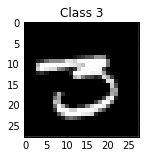

7812


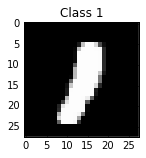

7856


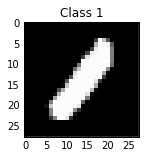

7899


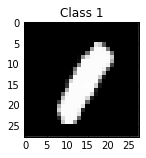

[7928 8062 8094 8095 8246 8255 8290 8339 8408]
7928


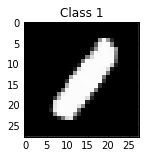

8062


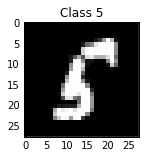

8094


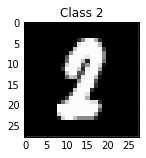

8095


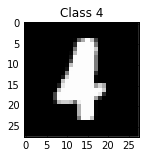

8246


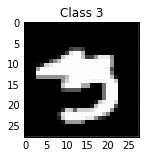

8255


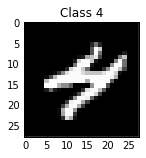

8290


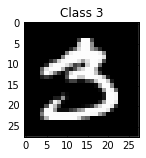

8339


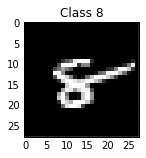

8408


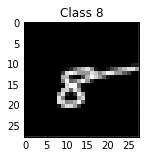

[8453 8527 9009 9015 9024 9587 9634 9664 9679]
8453


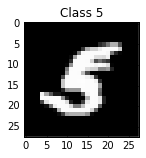

8527


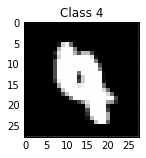

9009


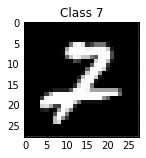

9015


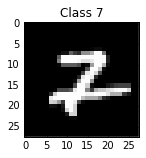

9024


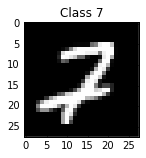

9587


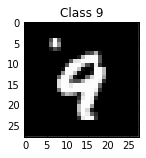

9634


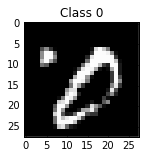

9664


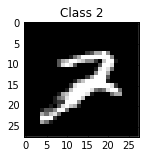

9679


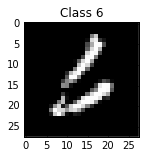

[9729 9745 9749 9768 9770 9839 9922]
9729


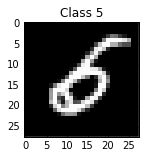

9745


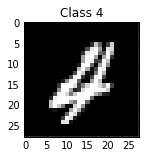

9749


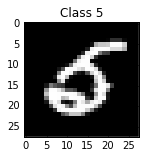

9768


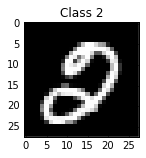

9770


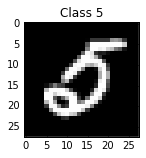

9839


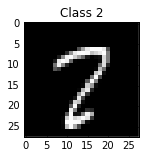

9922


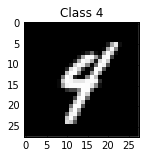

In [16]:
# display all the images that we got wrong
index = 0

while index < len(incorrect_indices):
    lot_indexes = incorrect_indices[index:index+9]
    print lot_indexes
    index = index + len(lot_indexes)
    i = 0
    for i in range(len(lot_indexes)):
        val = lot_indexes[i]
        print val
        plt.subplot(3,3,i+1)
        plt.imshow(X_test_org[val], cmap='gray', interpolation='none')
        plt.title("Class {}".format(y_test_org[val]))
        plt.show()

### Section 3 - Correct 1 mistake

In [17]:
# pick one mistake that will act as feedback

#index of the example
feedback_index = 65

# the original and modified X of
feedback_X_org = X_test_org[feedback_index]
feedback_X = X_test[feedback_index]

# correct label of data and 1-hot encoding
feedback_Y_org = y_test_org[feedback_index]
feedback_Y = Y_test[feedback_index]

In [18]:
# print optimizer values

m = model.get_config()

m['optimizer']

{'decay': 9.999999974752427e-07,
 'lr': 0.10000000149011612,
 'momentum': 0.8999999761581421,
 'name': 'SGD',
 'nesterov': True}

Actual class is : 4


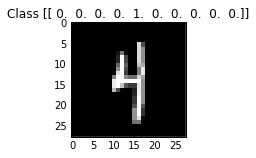

Predicted class is : 9


In [20]:
# print the actual label 
print "Actual class is : %d" %feedback_Y_org

# print the data point 
plt.subplot(3,3,3)
plt.imshow(feedback_X_org, cmap='gray', interpolation='none')
plt.title("Class {}".format(feedback_Y))
plt.show()

# get the data in format for prediction 
feedback_X = feedback_X.reshape(1,784)
feedback_Y = feedback_Y.reshape(1,10)

#get the model's prediction for this datapoint
feedback_prediction = model.predict_classes(feedback_X, verbose = 0)

print "Predicted class is : %d" %feedback_prediction

In [21]:
feedback_X.shape

(1, 784)

In [31]:
feedback_Y.shape

(1, 10)

In [23]:
no_of_attempts = 0
Success_Flag = False

while ( (feedback_prediction != feedback_Y_org) and (no_of_attempts< 200) ):
    
    no_of_attempts += 1
    
    model.fit(feedback_X, feedback_Y,
             batch_size = 1, nb_epoch = 1,
             show_accuracy=True, verbose=0)
    
    feedback_prediction = model.predict_classes(feedback_X, verbose = 2)
    
    if (feedback_prediction == feedback_Y_org):
        Success_Flag = True
        break
    
    print "Attempt Number %d,  Prediction for this iteration %d" %(no_of_attempts, feedback_prediction)
    
if ( (Success_Flag == False) and (no_of_attempts >= 200) ):
    print "\n Failed to incorporate this feedback"

if (Success_Flag == True) :    
    print "\nFeedback incorporated"
    print "Took %d iterations to Learn" %no_of_attempts

print "Time for general health checkup"
prediction_on_test_data()

    

Time for general health checkup
10000/10000 [==============================] - 0s     
# of correctly classified instances 7494
# of wrongly classified instances 2506
Accuracy = 74.94


(array([   0,    1,    2, ..., 9997, 9998, 9999]),
 array([   7,    9,   12, ..., 9991, 9992, 9993]))

In [23]:
feedback_prediction

array([4])

In [ ]:
import random

train_regret_list = []
test_regret_list = []

# store (loss,accuracy) for train and test data
train_score_list = []
test_score_list = []

REGRET_CHECKPOINT = 50
ITERATION_CHECKPOINT = 5000


for i in range(no_of_samples):
    
    # print info after consuming 1000 data points
    if ((i+1)%ITERATION_CHECKPOINT == 0):
        print("Example : %d", i)
        end_time = time()
        time_lapse = end_time - start_time
        print("Training on 1000 point took %.2f secs" %(end_time - start_time))
        start_time = time()
        #start_time = time()

    # train on ith data point
    sgd.lr = random.uniform(0.1, 0.9)
    
    
    model_online_tweek.fit(X_train[i:i+1,:], Y_train[i:i+1],
          batch_size, nb_epoch,
          show_accuracy=True, verbose=0)
    
    #calculate regret on train and test
    if ((i+1)%REGRET_CHECKPOINT == 0):
        
        # compute regrets and store it
        train_regret = compute_regret(model_online_1,X_train,y_train_org)
        test_regret = compute_regret(model_online_1,X_test,y_test_org)
        train_regret_list.append(train_regret)
        test_regret_list.append(test_regret)
        
        # compute scores and store them
        train_score = model_online_1.evaluate(X_train, Y_train, show_accuracy=True, verbose=0)
        test_score = model_online_1.evaluate(X_test, Y_test, show_accuracy=True, verbose=0)
        train_score_list.append(train_score)
        test_score_list.append(test_score)

In [34]:
x =  sgd.lr

In [35]:
x.get_value()

array(0.10000000149011612, dtype=float32)

In [18]:
model.get_weights()

[array([[ -1.88693888e-02,  -2.56399252e-02,  -3.05774212e-02, ...,
          -1.33983057e-03,  -6.65581673e-02,   5.74904382e-02],
        [ -6.21123763e-04,   4.03798819e-02,  -1.18590994e-02, ...,
           2.10316814e-02,   7.41493277e-05,   2.66619101e-02],
        [  5.96691594e-02,  -1.33584505e-02,   5.81052564e-02, ...,
          -5.90746216e-02,  -6.17077462e-02,  -7.14197755e-04],
        ..., 
        [ -3.17463912e-02,  -1.54519044e-02,   4.51090373e-02, ...,
           5.95218651e-02,  -2.60909460e-02,   1.07221287e-02],
        [ -9.95578896e-03,  -1.88277457e-02,   2.26518158e-02, ...,
           4.59142551e-02,  -4.28290293e-02,   3.61064747e-02],
        [ -1.78499203e-02,   3.30573246e-02,   2.69756913e-02, ...,
          -2.27523744e-02,  -1.96270621e-03,   3.36433016e-02]], dtype=float32),
 array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.

In [19]:
model.get_config()

{'class_mode': 'categorical',
 'layers': [{'W_constraint': None,
   'W_regularizer': None,
   'activation': 'linear',
   'activity_regularizer': None,
   'b_constraint': None,
   'b_regularizer': None,
   'cache_enabled': True,
   'custom_name': 'dense',
   'init': 'glorot_uniform',
   'input_dim': None,
   'input_shape': (784,),
   'name': 'Dense',
   'output_dim': 512,
   'trainable': True},
  {'activation': 'relu',
   'cache_enabled': True,
   'custom_name': 'activation',
   'name': 'Activation',
   'trainable': True},
  {'cache_enabled': True,
   'custom_name': 'dropout',
   'name': 'Dropout',
   'p': 0.4,
   'trainable': True},
  {'W_constraint': None,
   'W_regularizer': None,
   'activation': 'linear',
   'activity_regularizer': None,
   'b_constraint': None,
   'b_regularizer': None,
   'cache_enabled': True,
   'custom_name': 'dense',
   'init': 'glorot_uniform',
   'input_dim': None,
   'name': 'Dense',
   'output_dim': 512,
   'trainable': True},
  {'activation': 'relu',
   

In [20]:
model.compile(loss='categorical_crossentropy', optimizer=sgd)

In [78]:
from keras import backend as K

In [79]:
sgd.lr = K.variable(0.3)

In [80]:
sgd.lr.get_value()

array(0.30000001192092896, dtype=float32)

In [82]:
model_online_tweek.get_config()

{'class_mode': 'categorical',
 'layers': [{'W_constraint': None,
   'W_regularizer': None,
   'activation': 'linear',
   'activity_regularizer': None,
   'b_constraint': None,
   'b_regularizer': None,
   'cache_enabled': True,
   'custom_name': 'dense',
   'init': 'glorot_uniform',
   'input_dim': None,
   'input_shape': (784,),
   'name': 'Dense',
   'output_dim': 512,
   'trainable': True},
  {'activation': 'relu',
   'cache_enabled': True,
   'custom_name': 'activation',
   'name': 'Activation',
   'trainable': True},
  {'cache_enabled': True,
   'custom_name': 'dropout',
   'name': 'Dropout',
   'p': 0.4,
   'trainable': True},
  {'W_constraint': None,
   'W_regularizer': None,
   'activation': 'linear',
   'activity_regularizer': None,
   'b_constraint': None,
   'b_regularizer': None,
   'cache_enabled': True,
   'custom_name': 'dense',
   'init': 'glorot_uniform',
   'input_dim': None,
   'name': 'Dense',
   'output_dim': 512,
   'trainable': True},
  {'activation': 'relu',
   

In [83]:
m = model_online_tweek.get_config()

In [84]:
m.keys()

['layers', 'optimizer', 'class_mode', 'name', 'loss']

In [85]:
m['optimizer']['lr']

0.30000001192092896

In [55]:
type(m['optimizer']['lr'])

float

In [89]:
sgd.lr.set_value(0.8)

In [90]:
m = model_online_tweek.get_config()

In [91]:
m['optimizer']['lr']

0.800000011920929